<a href="https://colab.research.google.com/github/martinaturchini/HIV-1-cleavage-project/blob/main/HIV_CLEAVAGE_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HIV-1 Cleavage Prediction

This work shows the possibility to study and predict the HIV-1 cleavage sites given the combination of sequence information, including amino acid binary profiles, bond composition, and physicochemical properties. The best performances are obtained via the Multi-Layer Perceptron classifier and similar results can be obtained with the Logistic Regression classifier. The k-NN classifier is the worst among the methods analyzed in this work.
The results could be improved by using a larger data set, that can be implemented via data augmentation techniques.


To work with the code is necessary to download and save the data set (https://github.com/martinaturchini/HIV-1-cleavege-/blob/main/12859_2022_5017_MOESM2_ESM.xlsx) in "/content/gdrive/My Drive".

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras.optimizers import Optimizer, Adam
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from keras.callbacks import Callback, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from itertools import product

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [6]:
#uploading the data set into a dataframe

file_dir = '/content/gdrive/My Drive'

df_original = pd.read_excel(f"{file_dir}/12859_2022_5017_MOESM2_ESM.xlsx")

The data set is composed of 5848 octapeptides, of which 1001 are cleaved and 4847 are non-
cleaved. In every octapeptide, the cleavage site is always located between
the fourth and the fifth amino acids. Each octapeptide (octamer) is
composed of 8 amino acids in sequence (e.g. AECFRIFD). There are 20 different possible amino
acids that can be used to form an octapeptide, so there is a total of 20^8 = 2.56 × 10^10 possible combinations, but not every combination is present in the polyproteins produced by the HIV genome.
In the data set, each octamer is represented through a 178-dimension feature vector.

The target vector is a binary variable, assuming the value of 1 for cleaved sequences and
0 for non-cleaved sequences.

In [7]:
#displaying the data set

df=df_original

display(df)

df = df.iloc[:,1:]

,octamer,A1,C1,D1,E1,F1,G1,H1,I1,K1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
0,AECFRIFD,1,0,0,0,0,0,0,0,0,...,0.250,0.000,0.250,0.250,0.125,0.625,0.625,0.125,0.125,1
1,HLVEALYL,0,0,0,0,0,0,1,0,0,...,0.625,0.000,0.125,0.125,0.125,0.750,0.625,0.125,0.000,1
2,TQIMFETF,0,0,0,0,0,0,0,0,0,...,0.125,0.000,0.250,0.125,0.000,0.875,0.750,0.000,0.125,1
3,AEELAEIF,1,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.375,0.000,0.625,0.625,0.000,0.000,1
4,PFIFEEEP,0,0,0,0,0,0,0,0,0,...,0.375,0.250,0.250,0.375,0.000,0.625,0.625,0.250,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,YVPVTTFK,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.000,0.125,0.875,0.750,0.250,0.000,0
5844,YVQQHGGV,0,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.000,0.125,0.875,0.250,0.125,0.000,0
5845,YVSNIDGT,0,0,0,0,0,0,0,0,0,...,0.375,0.000,0.125,0.125,0.000,0.875,0.375,0.125,0.000,0
5846,YWPQEAGE,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.250,0.000,0.750,0.375,0.125,0.000,0


#Data Pre-processing

Number of non-cleaved sequences: 4847
Number of cleaved sequences: 1001
The data set is imbalanced


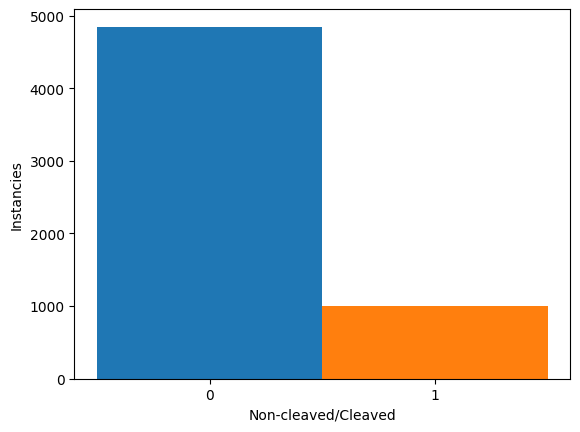

In [8]:
# Showing the data distribution divided between non-cleaved sequences (0) and
# cleaved sequences (1) in a histogram.

num_cleaved = df['cleavage Status'][df['cleavage Status'] == 1].count()
num_noncleaved = df['cleavage Status'][df['cleavage Status'] == 0].count()

df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print('Number of non-cleaved sequences:', num_noncleaved)
print('Number of cleaved sequences:', num_cleaved)

if num_noncleaved != num_cleaved:
  print('The data set is imbalanced')

Since the features are measured at very different scales, they do not contribute equally to the model
fitting and they might end up creating a bias towards a specific range. The features were scaled with
MinMaxScaler() because it works best when the data distribution is not gaussian, like the Amino Acid Binary Profile (AABP).

In [9]:
# Since Scikit-learn requires inputs to be in Numpy array format, I convert
# them using the function to_numpy()

df_X = df[df.columns[:178]]
df_y = df[df.columns[-1]]

X = df_X.to_numpy()
y = df_y.to_numpy()

X = MinMaxScaler().fit_transform(X)

In [11]:
# Splitting the data set in 3 subsets: training, test and validation to prevent
# the model from over-fitting and to evaluate it effectively.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33, shuffle=True, random_state=42,
    stratify=y_test)

The data set is heavily imbalanced: the non-cleaved octamers (0) far outweigh
the cleaved ones (1). Balancing the dataset is important to prevent the model from being biased towards
one class.

In [12]:
train_df = pd.DataFrame(X_train, columns = df_X.columns)
train_df['cleavage Status'] = y_train

cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 1]

# Cleaved entries (minority class) are 851 in the train set.
# Taking 851 entries from the non-cleaved sequence to match the cleaved ones
# using a random undersampling method
non_cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 0].sample(
    n=851, random_state=42)

# Concatenate both dataframes again
equalized_train_df = pd.concat([non_cleaved_train_df, cleaved_train_df])

display(equalized_train_df)

,A1,C1,D1,E1,F1,G1,H1,I1,K1,L1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
1071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.375,0.428571,0.000000,0
3219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.00,0.25,0.000,0.000000,1.000,0.375,0.000000,0.000000,0
3272,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.750,0.00,0.00,0.125,0.000000,0.875,0.500,0.000000,0.000000,0
2716,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.625,0.00,0.25,0.125,0.000000,0.875,0.375,0.000000,0.000000,0
3033,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.125,0.428571,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.625,0.25,0.00,0.000,0.000000,1.000,0.875,0.142857,0.333333,1
4953,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.125,0.00,0.25,0.125,0.166667,0.750,0.375,0.285714,0.000000,1
4959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250,0.25,0.00,0.250,0.000000,0.750,0.375,0.142857,0.333333,1
4961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.25,0.00,0.250,0.166667,0.625,0.625,0.285714,0.000000,1


Number of non-cleaved sequences in the training set: 851
Number of cleaved sequences in the training set: 851
Now the training set is balanced
Number of non-cleaved sequences in the validation set: 240
Number of cleaved sequences in the validation set: 50
Number of non-cleaved sequences in the test set: 488
Number of cleaved sequences in the test set: 100


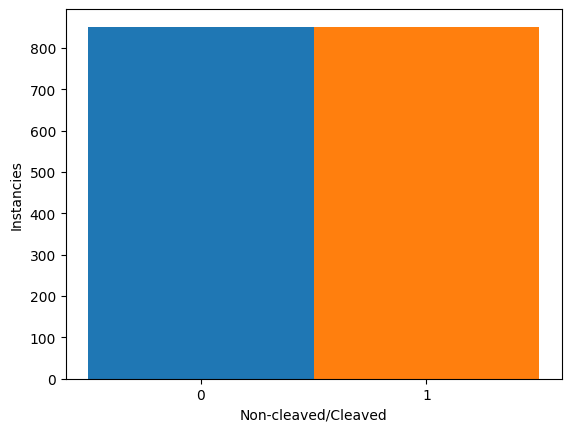

In [13]:
# Showing the instances for each class (test, training, validation)

num_cleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 1].count()
num_noncleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 0].count()

equalized_train_df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print('Number of non-cleaved sequences in the training set:', num_noncleaved_eq)
print('Number of cleaved sequences in the training set:', num_cleaved_eq)
print('Now the training set is balanced')

print('Number of non-cleaved sequences in the validation set:',
      np.count_nonzero(y_val==0))
print('Number of cleaved sequences in the validation set:',
      np.count_nonzero(y_val==1))

print('Number of non-cleaved sequences in the test set:',
      np.count_nonzero(y_test==0))
print('Number of cleaved sequences in the test set:',
      np.count_nonzero(y_test==1))

In [14]:
X_train = equalized_train_df[equalized_train_df.columns[:178]].to_numpy()
y_train = equalized_train_df[equalized_train_df.columns[-1]].to_numpy()

#Method 1: Dense Neural Network (DNN)

##Hyperparameter optimization

In [49]:
# The GridSearchCV method, from the Scikit-learn’s model selection package,
# was used for the hyperparameter tuning.

# define the grid search parameters
param_space = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01], #l2_lambda
    'learning_rate_init': [0.001, 0.0001],
    'batch_size' : [60, 64, 70],
    'max_iter' : [30, 35, 40] #epochs
}

model = MLPClassifier(random_state=1, max_iter=100)

grid_search = GridSearchCV(model, param_space, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters", best_params)
print("Best score", grid_search.best_score_)

Best hyperparameters {'alpha': 0.01, 'batch_size': 64, 'learning_rate_init': 0.001, 'max_iter': 30, 'solver': 'adam'}
Best score 0.9059910298430223


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


In [50]:
# Use the grid_search to make new predictions. For example, check the performance on the test set.
y_true, y_pred = y_test , grid_search.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       488
           1       0.68      0.94      0.79       100

    accuracy                           0.91       588
   macro avg       0.83      0.92      0.87       588
weighted avg       0.93      0.91      0.92       588



In [ ]:


param_space_layers = {
    'dropout': [0, 0.2, 0.4],
    'dense_nodes': [[8],[16],[32],[64],[128],
                    [8,4],[16,8],[32,16],[64,32]]
}

# Creating all the possible combination of hyperparameters
value_combis = product(*[v for v in param_space_layers.values()])

param_combis = [{key:value for key, value in zip(param_space_layers.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)


class HistoryEpoch(Callback):
  """For saving the accuracy and loss values obtained at the end of each epoch
     during the training.
  """

  def __init__(self, data):
        self.data = data

  def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# Creating and compiling a model for each combination
for idx, params in enumerate(param_combis):

    optimizer = Adam(learning_rate=best_params['learning_rate_init'])

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(X_train[0].shape))

    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu',
                      kernel_regularizer=l2(best_params['alpha'])))
      model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    #______________________________________________________________________________

    # choosing the best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0,
        save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=X_train,
      y=y_train,
      batch_size=best_params['batch_size'],
      epochs=best_params['max_iter'],
      validation_data=(X_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((X_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    train_loss_at_best_val_acc = fit_results.history['train_loss'][best_val_epoch]
    train_acc_at_best_val_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'train_acc_at_best_val_acc': train_acc_at_best_val_acc,
        'best_val_acc': best_val_acc,
        'train_loss_at_best_val_acc': train_loss_at_best_val_acc,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

In [53]:
# Comparison between different combination to find the one which perform better.

df_results = pd.DataFrame(search_results).sort_values(
    'best_val_acc', ascending=False)

# removing the only one critical hyperparameter set
df_results = df_results[df_results['train_acc_at_best_val_acc']>0.8]
df_results = df_results[df_results['best_val_acc']>0.8]
df_results = df_results[df_results['best_val_epoch']>10]

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_results)

,dropout,dense_nodes,train_acc_at_best_val_acc,best_val_acc,train_loss_at_best_val_acc,best_val_acc_loss,best_val_epoch,history
26,0.4,"[64, 32]",0.938,0.917,0.293,0.333,20,"{'loss': [1.829086184501648, 1.449325203895568..."
2,0.0,[32],0.931,0.910,0.266,0.292,29,"{'loss': [1.1133744716644287, 0.91157072782516..."
25,0.4,"[32, 16]",0.924,0.910,0.378,0.371,11,"{'loss': [1.3575206995010376, 1.17576134204864..."
22,0.4,[128],0.937,0.910,0.253,0.300,29,"{'loss': [1.8883895874023438, 1.32389354705810..."
21,0.4,[64],0.934,0.910,0.268,0.302,25,"{'loss': [1.4727838039398193, 1.14393126964569..."
8,0.0,"[64, 32]",0.937,0.910,0.271,0.308,27,"{'loss': [1.809846043586731, 1.358430624008178..."
13,0.2,[128],0.938,0.907,0.262,0.300,22,"{'loss': [1.8442143201828003, 1.26889574527740..."
10,0.2,[16],0.925,0.907,0.353,0.360,13,"{'loss': [0.9455978870391846, 0.84290456771850..."
15,0.2,"[16, 8]",0.942,0.903,0.293,0.383,27,"{'loss': [1.075927734375, 0.9705443382263184, ..."
20,0.4,[32],0.933,0.903,0.294,0.320,21,"{'loss': [1.1371350288391113, 0.94694209098815..."


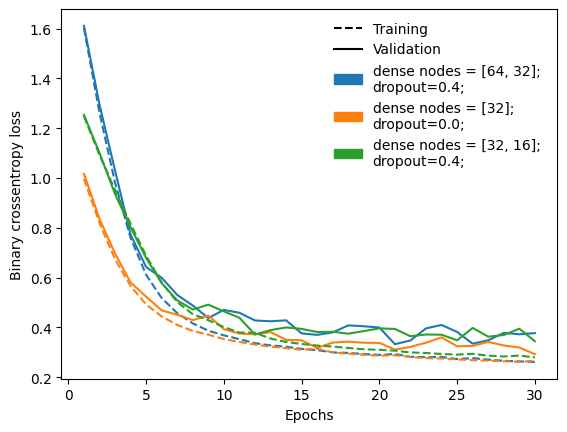

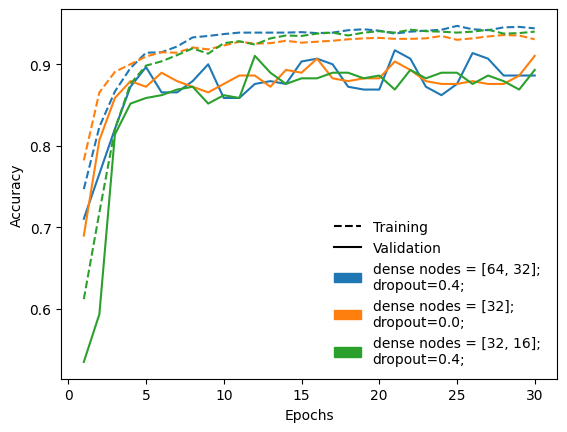

In [56]:
# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# plotting the loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df_results.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}; \ndropout={row_series['dropout']};"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

# and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)

plt.xlabel('Epochs')
plt.xticks(np.arange(0,32,step=5))
plt.ylabel('Binary crossentropy loss')

plt.legend(frameon=False)
plt.savefig(f"{file_dir}/HIV-CP Plots/Loss Gridsearch.png")
plt.show()


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# plotting the accuracy curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df_results.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}; \ndropout={row_series['dropout']};"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

# and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.xticks(np.arange(0,32,step=5))
plt.ylabel('Accuracy')

plt.legend(frameon=False)
plt.savefig(f"{file_dir}/HIV-CP Plots/Accuracy Gridsearch.png")
plt.show()

##Models

In [57]:
def plot_history(network_history, mod_num):
 """
    Plotting loss and accuracy values obtained for each epoch.
 """
 plt.figure()
 plt.xlabel('Epochs')
 plt.ylabel('Loss')
 plt.plot(network_history.history['loss'], '--')
 plt.plot(network_history.history['val_loss'], '-')
 plt.legend(['Training', 'Validation'],
              frameon=False)
 plt.savefig(f"{file_dir}//HIV-CP Plots/Loss MLP "+mod_num+".png")

 plt.figure()
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy')
 plt.plot(network_history.history['accuracy'], '--')
 plt.plot(network_history.history['val_accuracy'], '-')
 plt.legend(['Training', 'Validation'],
             loc='lower right', frameon=False)
 plt.savefig(f"{file_dir}//HIV-CP Plots/Accuracy MLP "+mod_num+".png")

 plt.show()

In [58]:
# The training and validation loss of the fit history are not comparable when
# using dropout, so I have to define a callback function.

class HistoryEpoch(Callback):
  """
    Callback function which calculates the loss and the metric after each epoch
  """
  def __init__(self, data):
        self.data = data

  def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

  def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
test_hist=HistoryEpoch((X_test, y_test))

From the best results on the hyperparameters obtained with the GridSearchCV, I have manually built 3 models. Each one of them has its accuracy vs epochs and loss vs epochs plotted.

In [60]:
#Model 1
learning_rate = 0.001
alpha = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model1 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(alpha),
            input_dim=178),
      Dropout(dropout),
      Dense(32, activation='relu', kernel_regularizer=l2(alpha)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model1.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model1.summary()

history1 = model1.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_219"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_533 (Dense)           (None, 64)                11456     
                                                                 
 dropout_315 (Dropout)       (None, 64)                0         
                                                                 
 dense_534 (Dense)           (None, 32)                2080      
                                                                 
 dropout_316 (Dropout)       (None, 32)                0         
                                                                 
 dense_535 (Dense)           (None, 1)                 33        
                                                                 
Total params: 13569 (53.00 KB)
Trainable params: 13569 (53.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
27/27

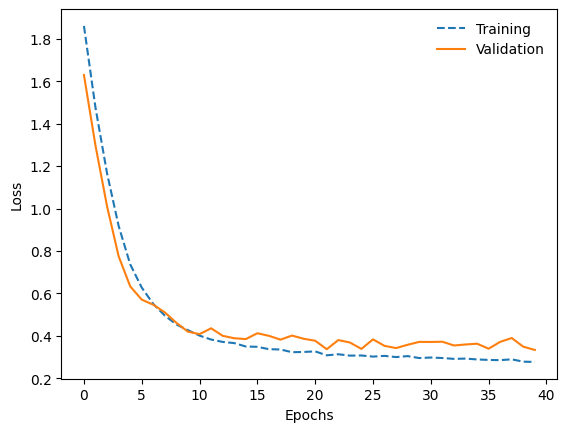

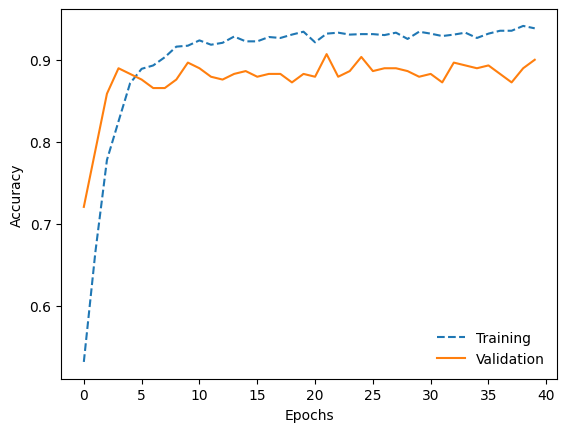

In [61]:
plot_history(history1, '1')

In [62]:
#Model 2
learning_rate = 0.001
alpha = 0.01
dropout = 0
optimizer = Adam(learning_rate=learning_rate)

model2 = Sequential([
      Dense(32, activation='relu', kernel_regularizer=l2(alpha),
            input_dim=178),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model2.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model2.summary()

history2 = model2.fit(x=X_train, y=y_train, batch_size=64, epochs=30,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_536 (Dense)           (None, 32)                5728      
                                                                 
 dropout_317 (Dropout)       (None, 32)                0         
                                                                 
 dense_537 (Dense)           (None, 1)                 33        
                                                                 
Total params: 5761 (22.50 KB)
Trainable params: 5761 (22.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
27/27 [==============================] - 5s 72ms/step - loss: 1.1388 - accuracy: 0.5482 - val_loss: 1.0715 - val_accuracy: 0.5379
Epoch 2/30
27/27 [==============================] - 1s 50ms/step - loss: 0.9355 - accuracy: 0.7291 - val_loss: 0.8889 - val_accuracy: 0.7241


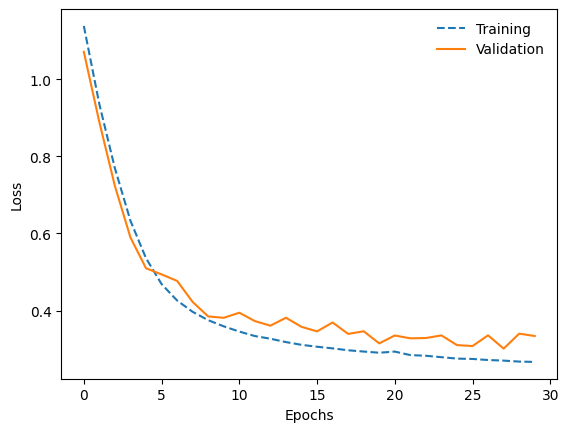

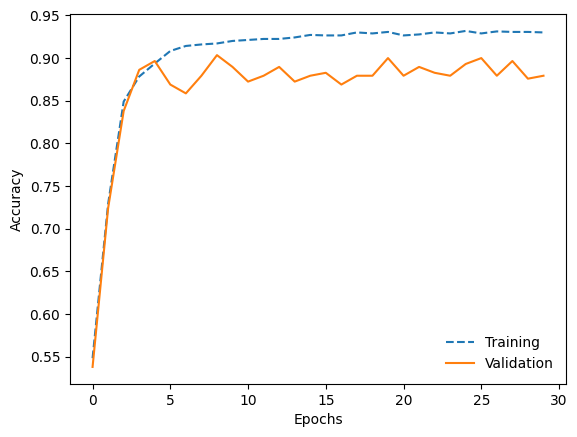

In [63]:
plot_history(history2,'2')

In [64]:
# Model 3
learning_rate = 0.001
alpha = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model3 = Sequential([
      Dense(32, activation='relu', kernel_regularizer=l2(alpha),
            input_dim=178),
      Dropout(dropout),
      Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model3.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model3.summary()

history3 = model3.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val))

Model: "sequential_221"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_538 (Dense)           (None, 32)                5728      
                                                                 
 dropout_318 (Dropout)       (None, 32)                0         
                                                                 
 dense_539 (Dense)           (None, 16)                528       
                                                                 
 dropout_319 (Dropout)       (None, 16)                0         
                                                                 
 dense_540 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6273 (24.50 KB)
Trainable params: 6273 (24.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
27/27 [

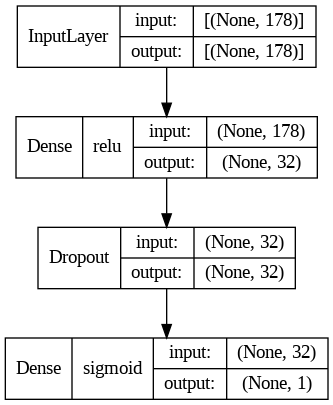

In [66]:
# displaying the network architecture for one of the models (Model 2) as an example

plot_model(model2, to_file='model_plot.png', show_shapes=True,
           show_layer_names=False, show_layer_activations=True)
Image('model_plot.png')

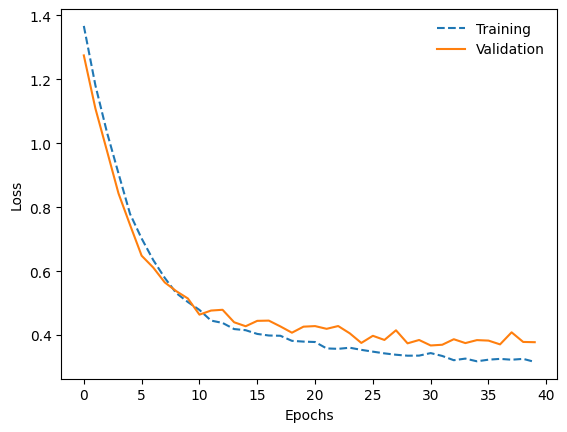

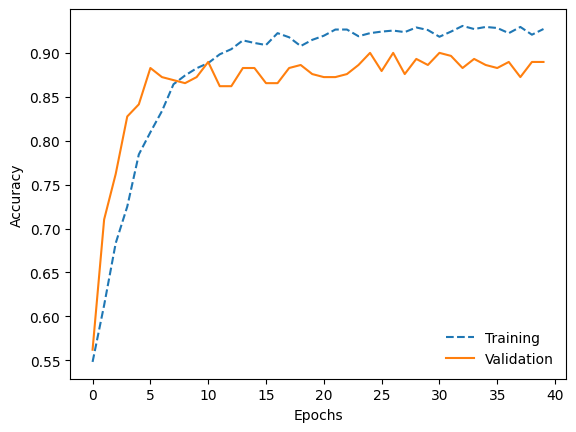

In [67]:
plot_history(history3,'3')

##Evaluation



In [68]:
def plot_confusion_matrix(cm, classes, method,
                          normalize=False,
                          title='Confusion matrix ',
                          cmap=plt.cm.Blues, mod_num=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + method + mod_num)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.savefig(f"{file_dir}//HIV-CP Plots/Confusion matrix "+
                method + mod_num + ".png")
    plt.show()

In [69]:
def evaluate(x_test, Y_test, model, mod_num):

    #Evaluate loss and metrics
    loss, accuracy = model.evaluate(x_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)

    # Predict the values from the test dataset
    Y_pred = model.predict(x_test)

    Y_cls = [0]
    for i in range(len(Y_pred)):
      if Y_pred[i] <= 0.5:
        Y_cls = np.append(Y_cls,0)
      else:
        Y_cls = np.append(Y_cls,1)
    Y_cls = Y_cls[1:]

    cr = classification_report(Y_test, Y_cls, output_dict=True)
    print('Classification Report:\n', classification_report(Y_test,Y_cls))

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_test, Y_cls)

    tn=confusion_mtx[0][0]
    fp=confusion_mtx[0][1]
    fn=confusion_mtx[1][0]
    tp=confusion_mtx[1][1]

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = cr['weighted avg']['f1-score']

    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

    print('AUC:', auc(fpr,tpr))
    print('Sensitivity:', sensitivity)
    print('Specificity:', specificity)
    print('Average of performance metrics:',
          (accuracy+sensitivity+specificity+auc(fpr,tpr)+f1)/5)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = (0,1), method="MLP ",
                          mod_num=mod_num)

    disp = ConfusionMatrixDisplay.from_predictions(Y_test,Y_cls,
                                                   display_labels=(0,1),
                                                   cmap=plt.cm.Blues,
                                                   normalize='true')

    disp.ax_.set_title("Normalized confusion matrix MLP "+mod_num)

    plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix MLP "+
                mod_num + ".png")
    plt.show()

    #creating ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Test Loss: 0.29181963205337524
Test Accuracy: 0.9217687249183655
19/19 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       488
           1       0.72      0.89      0.79       100

    accuracy                           0.92       588
   macro avg       0.85      0.91      0.87       588
weighted avg       0.93      0.92      0.92       588

AUC: 0.9658811475409836
Sensitivity: 0.89
Specificity: 0.9282786885245902
Average of performance metrics: 0.9261804243673704


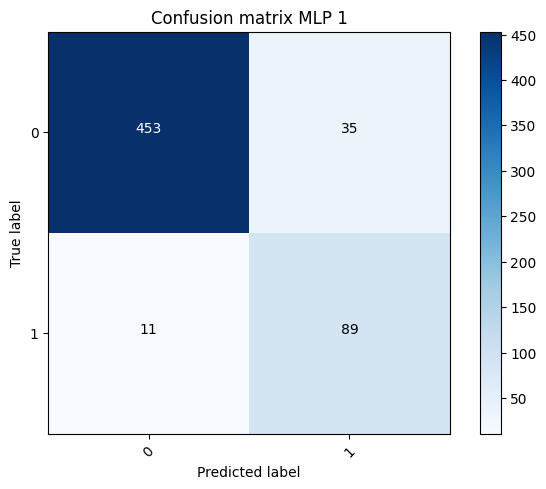

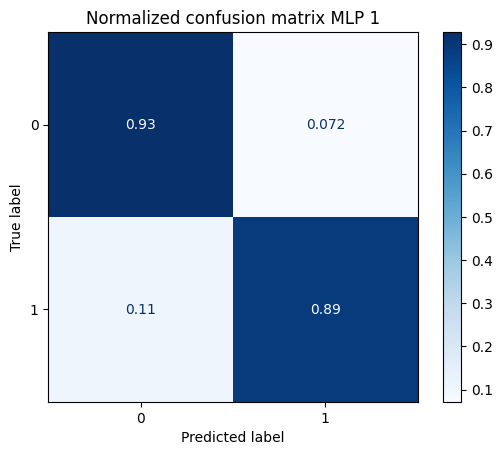

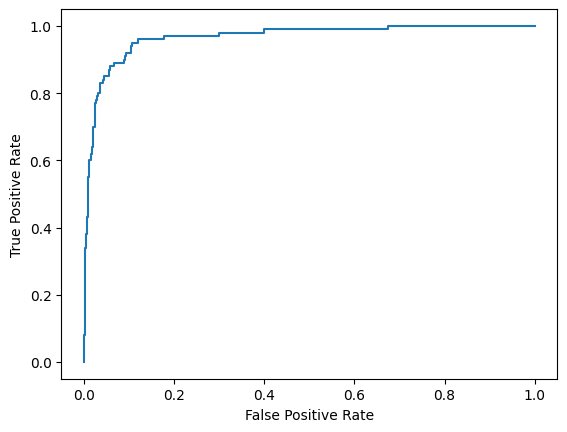

In [71]:
evaluate(X_test, y_test, model1, '1')

Test Loss: 0.2985493242740631
Test Accuracy: 0.9098639488220215
19/19 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       488
           1       0.67      0.94      0.78       100

    accuracy                           0.91       588
   macro avg       0.83      0.92      0.86       588
weighted avg       0.93      0.91      0.92       588

AUC: 0.964672131147541
Sensitivity: 0.94
Specificity: 0.9036885245901639
Average of performance metrics: 0.9267558959696409


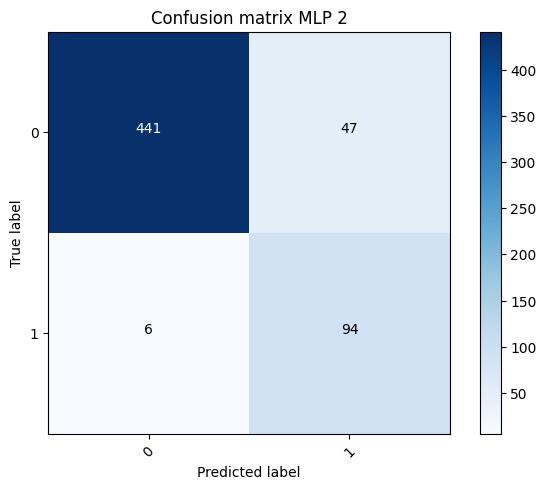

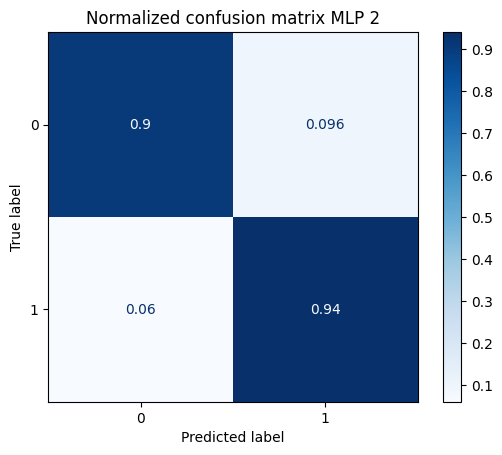

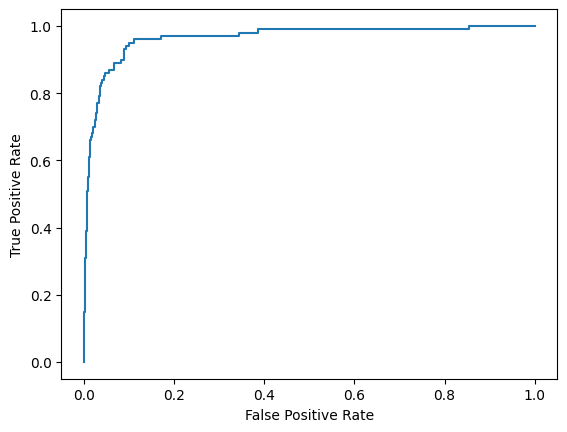

In [70]:
evaluate(X_test, y_test, model2, '2')

Test Loss: 0.3296370804309845
Test Accuracy: 0.9098639488220215
19/19 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       488
           1       0.67      0.92      0.78       100

    accuracy                           0.91       588
   macro avg       0.83      0.91      0.86       588
weighted avg       0.93      0.91      0.92       588

AUC: 0.9660655737704917
Sensitivity: 0.92
Specificity: 0.9077868852459017
Average of performance metrics: 0.9237680893392973


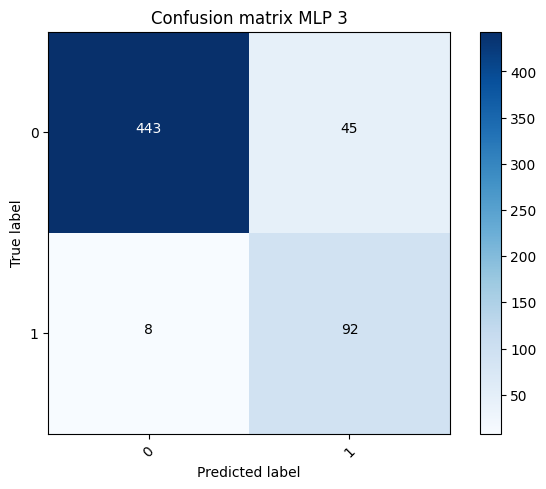

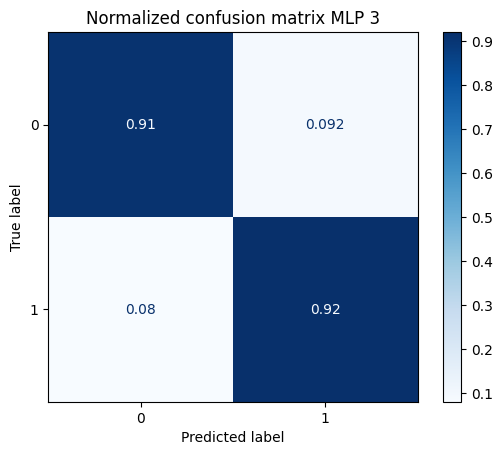

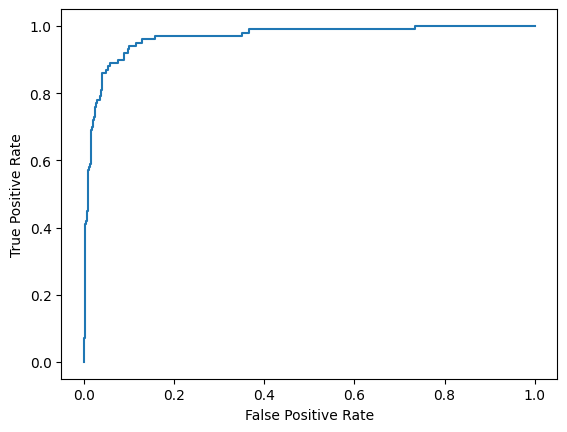

In [72]:
evaluate(X_test, y_test, model3, '3')

# Method 2: *k*-NN

In k-NN classification, the output is a member of a class. An object is classified as belonging to the class most common among its k nearest neighbors, where k is a positive integer, typically small. In this project, k = 4 was the one with the best results.

In [73]:
X_train_am = X_train
y_train_am = y_train

X_test_am = np.concatenate((X_test,X_val), axis=0)
y_test_am = np.concatenate((y_test,y_val), axis=0)

Accuracy: 0.83
B. Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       728
           1       0.51      0.85      0.64       150

    accuracy                           0.83       878
   macro avg       0.74      0.84      0.76       878
weighted avg       0.89      0.83      0.85       878

AUC: 0.9021336996336995
Sensitivity: 0.8533333333333334
Specificity: 0.8296703296703297
F1-score: 0.8485457022917298
Average of performance metrics: 0.8534792097967525


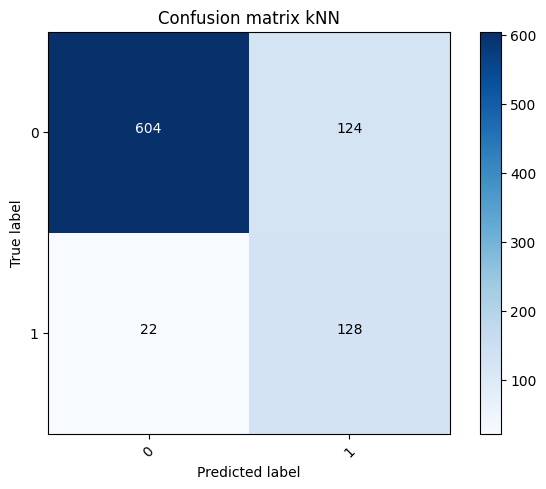

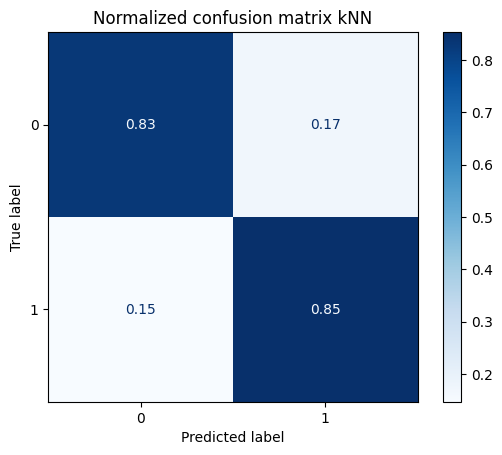

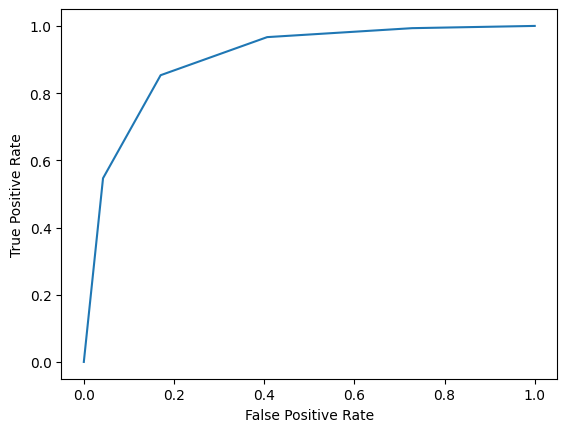

In [83]:
kn = KNeighborsClassifier(n_neighbors=4)

kn.fit(X_train_am, y_train_am)

y_prob_kNN = kn.predict_proba(X_test_am)
y_pred_kNN = kn.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_kNN))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_kNN))
print('Classification Report:\n', classification_report(y_test_am, y_pred_kNN))

cr = classification_report(y_test_am, y_pred_kNN, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_kNN)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

accuracy = accuracy_score(y_test_am, y_pred_kNN)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']

fpr2, tpr2, thresholds2 = roc_curve(y_test_am, y_prob_kNN[:,1])
auc2 = auc(fpr2,tpr2)

print('AUC:', auc2)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('F1-score:', f1)
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc2+f1)/5)

plot_confusion_matrix(confusion_mtx, classes = (0,1), method="kNN")

disp = ConfusionMatrixDisplay.from_estimator(kn, X_test_am, y_test_am,
                                             display_labels=(0,1),
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix kNN")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix kNN.png")
plt.show()

plt.plot(fpr2,tpr2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Method 3: Logistic Regression

Accuracy: 0.91
B. Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       728
           1       0.66      0.92      0.77       150

    accuracy                           0.91       878
   macro avg       0.82      0.91      0.85       878
weighted avg       0.93      0.91      0.91       878

AUC: 0.9634615384615384
Sensitivity: 0.92
Specificity: 0.9024725274725275
F1-score: 0.9112387812508975
Average of performance metrics: 0.9205279635144414


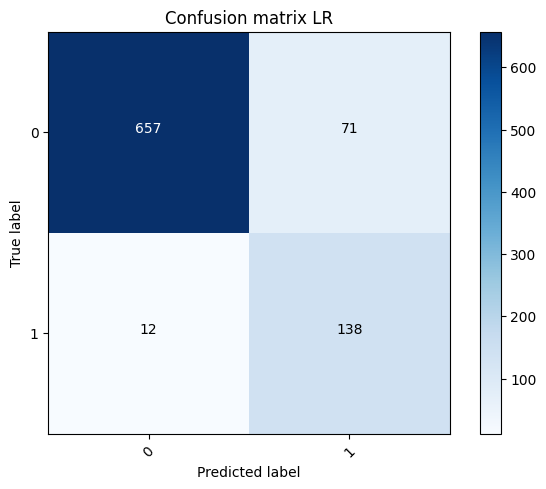

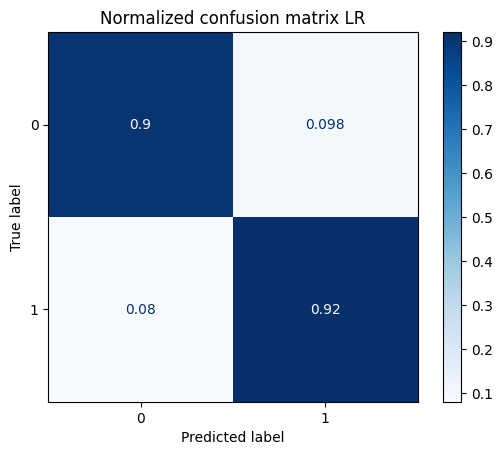

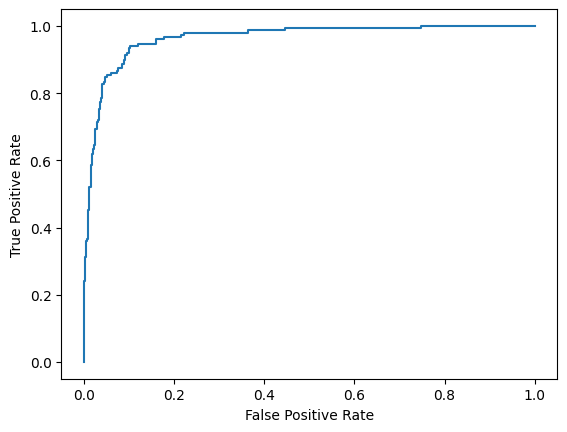

In [75]:
lr = LogisticRegression(solver='lbfgs',
                        multi_class='ovr',
                        penalty='l2',
                        n_jobs=-1,
                        random_state=42)

lr.fit(X_train_am, y_train_am)

y_prob_lr = lr.predict_proba(X_test_am)
y_pred_lr = lr.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_lr))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_lr))
print('Classification Report:\n', classification_report(y_test_am, y_pred_lr))

cr = classification_report(y_test_am, y_pred_lr, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_lr)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

accuracy = accuracy_score(y_test_am, y_pred_lr)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']

fpr3, tpr3, thresholds3 = roc_curve(y_test_am, y_prob_lr[:,1])
auc3 = auc(fpr3,tpr3)

print('AUC:', auc3)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('F1-score:', f1)
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc3+f1)/5)

plot_confusion_matrix(confusion_mtx, classes = (0,1), method="LR")

disp = ConfusionMatrixDisplay.from_estimator(lr, X_test_am, y_test_am,
        display_labels=(0,1), cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix LR")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix LR.png")
plt.show()

plt.plot(fpr3,tpr3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#ROC curves comparison


The results are compared using the ROC curves.
The best performances are obtained via the Multi-Layer Perceptron classifier and similar results can be obtained with the Logistic Regression classifier. The k-NN classifier is the worst among the methods analyzed in this work.

In [84]:
def compare_roccurves():
  """
  To compare the different results obtained with the 3 methods.
  """
  plt.figure()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  y_pred_MLP = model3.predict(X_test)
  fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_MLP)

  plt.plot(fpr1,tpr1)
  plt.plot(fpr2,tpr2)
  plt.plot(fpr3,tpr3)

  plt.legend(['MLP','kNN','LR'], frameon=False)
  plt.savefig(f"{file_dir}//HIV-CP Plots/ROC.png")

  plt.show()

19/19 [==============================] - 0s 2ms/step


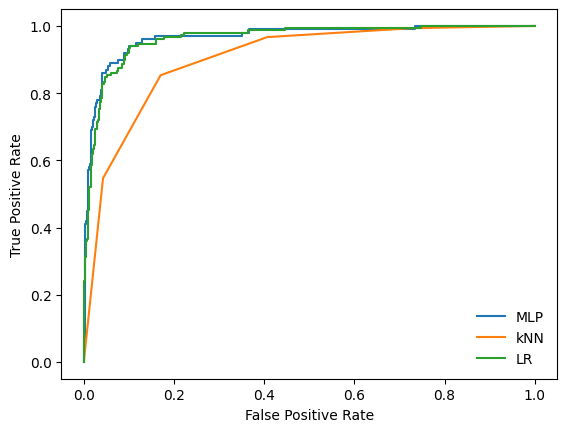

In [85]:
compare_roccurves()